[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Basketball AI: Automatic Detection of 3-Second Violation

---

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/basketball-ai-automatic-detection-of-3-second-violations.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/detect-3-second-violation-ai-basketball)

![3-second-violations-1](https://media.roboflow.com/notebooks/basketball-ai-automatic-detection-of-3-second-violations-1.png)

![3-second-violations-2](https://media.roboflow.com/notebooks/basketball-ai-automatic-detection-of-3-second-violations-2.png)


## Before you start

### Configure your API key

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

### Install dependencies

**Note:** The following commands will install all the required libraries for this notebook. The `gdown` library is used to download example data from Google Drive. We use `inference-gpu` to run RF-DETR for player detection and a keypoint detection model for basketball court key points on GPUs. `transformers` is needed to run ViTPose++ for player pose estimation. We use `supervision` to parse, process, and visualize model results, and the `sports` package provides basketball-specific utilities. This setup ensures you have everything needed for object detection, keypoint detection, pose estimation, and basketball analytics on GPU.


In [ ]:
!pip install -q gdown transformers
!pip install -q inference-gpu
!pip install -q git+https://github.com/roboflow/supervision.git@feature/advanced_keypoints_indexing_and_slicing
!pip install -q git+https://github.com/roboflow/sports.git@feat/basketball_radar

**Note:** Set the ONNX Runtime execution provider to CUDA to ensure model inference runs on the GPU.

In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
!cd $HOME/segment-anything-2-real-time/checkpoints && bash download_ckpts.sh

### Download the sample data

**Note:** Download the sample video file using `gdown`. This file will be used for testing player detection and tracking.

In [ ]:
!cd $HOME && gdown https://drive.google.com/uc?id=1ZPVTJyXnEdyxdBEntLqp5YFRicwy07Vx

In [ ]:
from pathlib import Path

SOURCE_VIDEO_PATH = Path(HOME) / "college2.mp4"
SOURCE_VIDEO_PATH

### Define some visualization utils

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple

def convert_to_grayscale(image: np.ndarray) -> np.ndarray:
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2BGR)


def replace_masked_regions(
    source_frame: np.ndarray,
    target_frame: np.ndarray,
    masks: List[np.ndarray]
) -> np.ndarray:
    result_frame = target_frame.copy()

    for mask in masks:
        if mask.ndim == 3:
            mask = np.squeeze(mask)

        if mask.dtype != bool:
            mask = mask.astype(bool)

        mask_rgb = np.repeat(mask[:, :, None], 3, axis=2)
        result_frame[mask_rgb] = source_frame[mask_rgb]

    return result_frame

## ball, number, player, referee and basket detection

In [ ]:
from inference import get_model
from google.colab import userdata
import supervision as sv

PLAYER_DETECTION_MODEL_ID = "basketball-player-detection-2/12"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key =  userdata.get("ROBOFLOW_API_KEY"))

COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

In [ ]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.35)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

In [ ]:
from tqdm import tqdm
from pathlib import Path

TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.parent / f"{SOURCE_VIDEO_PATH.stem}-detections{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for index, frame in tqdm(enumerate(frame_generator)):

        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.5)[0]
        detections = sv.Detections.from_inference(result)

        labels = [
            f"{class_name} {confidence:.2f}"
            for class_name, confidence
            in zip(detections['class_name'], detections.confidence)
        ]

        annotated_frame = frame.copy()
        annotated_frame = convert_to_grayscale(annotated_frame)
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=detections)
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels)
        sink.write_frame(annotated_frame)

In [ ]:
%%capture
!ffmpeg -y -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

## detect players

In [ ]:
box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2)
label_annotator = sv.LabelAnnotator(color=COLOR, text_color=sv.Color.BLACK)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.35)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == 2]

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## detect basketball court keypoints

In [ ]:
from inference import get_model
from google.colab import userdata

COURT_DETECTION_MODEL_ID = "basketball-court-detection-2/10"
COURT_DETECTION_MODEL = get_model(model_id=COURT_DETECTION_MODEL_ID, api_key =  userdata.get("ROBOFLOW_API_KEY"))

MAGENTA_COLOR = sv.Color.from_hex('#FF1493')
CYAN_COLOR = sv.Color.from_hex('#00BFFF')

In [ ]:
vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = COURT_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

In [ ]:
vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = COURT_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)
key_points = key_points[:, key_points.confidence[0] > 0.5]

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

## project lines and missing points

In [ ]:
from sports.common.view import ViewTransformer
from sports.configs.basketball import BasketballCourtConfiguration

KEYPOINT_CONFIDENCE_THRESHOLD = 0.5
DETECTION_CONFIDENCE = 0.3

CONFIG = BasketballCourtConfiguration()
EDGES = [(p1 + 1, p2 + 1) for p1, p2 in CONFIG.edges]

detected_vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)
projected_vertex_annotator = sv.VertexAnnotator(color=CYAN_COLOR, radius=8)

projected_edge_annotator = sv.EdgeAnnotator(
    color=CYAN_COLOR,
    thickness=2,
    edges=EDGES
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = COURT_DETECTION_MODEL.infer(frame, confidence=DETECTION_CONFIDENCE)[0]
key_points = sv.KeyPoints.from_inference(result)
filter = key_points.confidence[0] > KEYPOINT_CONFIDENCE_THRESHOLD
detected_key_points = key_points[:, filter]

source_reference_xy = np.array(CONFIG.vertices)[filter]
target_reference_xy = detected_key_points.xy[0]

transformer = ViewTransformer(
    source=source_reference_xy,
    target=target_reference_xy
)

source_xy = np.array(CONFIG.vertices)
target_xy = transformer.transform_points(points=source_xy)

projected_key_points = sv.KeyPoints(xy=target_xy[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = projected_edge_annotator.annotate(
    scene=annotated_frame,
    key_points=projected_key_points)
annotated_frame = projected_vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=projected_key_points)
annotated_frame = detected_vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=detected_key_points)

sv.plot_image(annotated_frame)

## detect the paint

In [ ]:
from sports.common.view import ViewTransformer
from sports.configs.basketball import BasketballCourtConfiguration

LEFT_PAINT_INDICES = [2, 3, 11, 9]
RIGHT_PAINT_INDICES = [21, 23, 30, 29]
POLYGONS_INDICES = [LEFT_PAINT_INDICES, RIGHT_PAINT_INDICES]
KEYPOINT_CONFIDENCE_THRESHOLD = 0.5
DETECTION_CONFIDENCE = 0.3

CONFIG = BasketballCourtConfiguration()
EDGES = [(p1 + 1, p2 + 1) for p1, p2 in CONFIG.edges]

detected_vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)
projected_vertex_annotator = sv.VertexAnnotator(color=CYAN_COLOR, radius=8)

projected_edge_annotator = sv.EdgeAnnotator(
    color=CYAN_COLOR,
    thickness=2,
    edges=EDGES
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = COURT_DETECTION_MODEL.infer(frame, confidence=DETECTION_CONFIDENCE)[0]
key_points = sv.KeyPoints.from_inference(result)
filter = key_points.confidence[0] > KEYPOINT_CONFIDENCE_THRESHOLD
detected_key_points = key_points[:, filter]

source_reference_xy = np.array(CONFIG.vertices)[filter]
target_reference_xy = detected_key_points.xy[0]

transformer = ViewTransformer(
    source=source_reference_xy,
    target=target_reference_xy
)

source_xy = np.array(CONFIG.vertices)
target_xy = transformer.transform_points(points=source_xy)

projected_key_points = sv.KeyPoints(xy=target_xy[np.newaxis, ...])

annotated_frame = frame.copy()

for indices in POLYGONS_INDICES:
    polygon = target_xy[indices].astype(int)

    annotated_frame = sv.draw_filled_polygon(
        scene=annotated_frame,
        polygon=polygon,
        color=CYAN_COLOR,
        opacity=0.6
    )

annotated_frame = projected_edge_annotator.annotate(
    scene=annotated_frame,
    key_points=projected_key_points)
annotated_frame = projected_vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=projected_key_points)
annotated_frame = detected_vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=detected_key_points)

sv.plot_image(annotated_frame)

In [ ]:
from tqdm import tqdm
from pathlib import Path

from sports.common.view import ViewTransformer
from sports.configs.basketball import BasketballCourtConfiguration

TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.parent / f"{SOURCE_VIDEO_PATH.stem}-paint{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

LEFT_PAINT_INDICES = [2, 3, 11, 9]
RIGHT_PAINT_INDICES = [21, 23, 30, 29]
POLYGONS_INDICES = [LEFT_PAINT_INDICES, RIGHT_PAINT_INDICES]
KEYPOINT_CONFIDENCE_THRESHOLD = 0.5
DETECTION_CONFIDENCE = 0.3

CONFIG = BasketballCourtConfiguration()
EDGES = [(p1 + 1, p2 + 1) for p1, p2 in CONFIG.edges]

detected_vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)
projected_vertex_annotator = sv.VertexAnnotator(color=CYAN_COLOR, radius=8)

projected_edge_annotator = sv.EdgeAnnotator(
    color=CYAN_COLOR,
    thickness=2,
    edges=EDGES
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for index, frame in tqdm(enumerate(frame_generator)):

        result = COURT_DETECTION_MODEL.infer(frame, confidence=DETECTION_CONFIDENCE)[0]
        key_points = sv.KeyPoints.from_inference(result)
        filter = key_points.confidence[0] > KEYPOINT_CONFIDENCE_THRESHOLD
        detected_key_points = key_points[:, filter]

        source_reference_xy = np.array(CONFIG.vertices)[filter]
        target_reference_xy = detected_key_points.xy[0]

        transformer = ViewTransformer(
            source=source_reference_xy,
            target=target_reference_xy
        )

        source_xy = np.array(CONFIG.vertices)
        target_xy = transformer.transform_points(points=source_xy)

        projected_key_points = sv.KeyPoints(xy=target_xy[np.newaxis, ...])

        annotated_frame = frame.copy()
        annotated_frame = convert_to_grayscale(annotated_frame)

        for indices in POLYGONS_INDICES:
            polygon = target_xy[indices].astype(int)

            annotated_frame = sv.draw_filled_polygon(
                scene=annotated_frame,
                polygon=polygon,
                color=CYAN_COLOR,
                opacity=0.6
            )

        annotated_frame = projected_edge_annotator.annotate(
            scene=annotated_frame,
            key_points=projected_key_points)
        annotated_frame = projected_vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=projected_key_points)
        annotated_frame = detected_vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=detected_key_points)
        sink.write_frame(annotated_frame)

In [ ]:
%%capture
!ffmpeg -y -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

## track end segment the players

In [ ]:
%cd $HOME/segment-anything-2-real-time

In [ ]:
from sam2.build_sam import build_sam2_camera_predictor

SAM2_CHECKPOINT = "checkpoints/sam2.1_hiera_large.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_camera_predictor(SAM2_CONFIG, SAM2_CHECKPOINT)

In [ ]:
import cv2
import torch
from tqdm import tqdm

PLAYER_ID = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
INTERVAL = 30

mask_annotator = sv.MaskAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    opacity=0.7)
box_annotator = sv.BoxAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2
)

annotated_frames = []

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == PLAYER_ID]

XYXY = detections.xyxy
CLASS_ID = detections.class_id
TRACKE_ID = list(range(1, len(CLASS_ID) + 1))

detections = sv.Detections(
    xyxy=XYXY,
    tracker_id=np.array(TRACKE_ID)
)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
sv.plot_image(annotated_frame)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.load_first_frame(frame)

    for xyxy, tracker_id in zip(XYXY, TRACKE_ID):
        xyxy = np.array([xyxy])

        _, object_ids, mask_logits = predictor.add_new_prompt(
            frame_idx=0,
            obj_id=tracker_id,
            bbox=xyxy
        )

for index, frame in tqdm(enumerate(frame_generator)):

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        tracker_ids, mask_logits = predictor.track(frame)
        tracker_ids = np.array(tracker_ids)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=tracker_ids
        )

    if index % INTERVAL == 0:

        annotated_frame = frame.copy()
        annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frames.append(annotated_frame)

In [ ]:
images = annotated_frames[:5]
titles = [f"frame {index * INTERVAL}" for index in range(0, len(images))]

sv.plot_images_grid(
    images=images,
    grid_size=(5, 1),
    size=(5, 15),
    titles=titles
)

In [ ]:
sv.plot_image(annotated_frames[-1])

## clean noisy masks

In [ ]:
import numpy as np
import cv2

def filter_segments_by_area(mask: np.ndarray, area_threshold: int) -> np.ndarray:
    """
    Keeps the main segment and removes other segments below area_threshold.

    Args:
        mask (np.ndarray): Boolean mask.
        area_threshold (int): Minimum area to keep a segment.

    Returns:
        np.ndarray: Boolean mask after filtering.
    """
    assert mask.dtype == bool, "Input mask must be boolean."
    mask_uint8 = mask.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
    if num_labels <= 1:
        return mask.copy()
    main_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    filtered_mask = np.zeros_like(mask, dtype=bool)
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if label == main_label or area >= area_threshold:
            filtered_mask[labels == label] = True
    return filtered_mask


def filter_segments_by_distance(mask: np.ndarray, distance_threshold: float) -> np.ndarray:
    """
    Keeps the main segment and removes segments farther than distance_threshold.

    Args:
        mask (np.ndarray): Boolean mask.
        distance_threshold (float): Maximum allowed distance from the main segment.

    Returns:
        np.ndarray: Boolean mask after filtering.
    """
    assert mask.dtype == bool, "Input mask must be boolean."
    mask_uint8 = mask.astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
    if num_labels <= 1:
        return mask.copy()
    main_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    main_centroid = centroids[main_label]
    filtered_mask = np.zeros_like(mask, dtype=bool)
    for label in range(1, num_labels):
        centroid = centroids[label]
        dist = np.linalg.norm(centroid - main_centroid)
        if label == main_label or dist <= distance_threshold:
            filtered_mask[labels == label] = True
    return filtered_mask

In [ ]:
PLAYER_ID = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
INTERVAL = 30

mask_annotator = sv.MaskAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    opacity=0.7)
box_annotator = sv.BoxAnnotator(
    color=COLOR,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2
)

annotated_frames_before = []
annotated_frames_after = []

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == PLAYER_ID]

XYXY = detections.xyxy
CLASS_ID = detections.class_id
TRACKER_ID = list(range(1, len(CLASS_ID) + 1))

detections = sv.Detections(
    xyxy=XYXY,
    tracker_id=np.array(TRACKER_ID)
)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.load_first_frame(frame)

    for xyxy, tracker_id in zip(XYXY, TRACKER_ID):
        xyxy = np.array([xyxy])

        _, object_ids, mask_logits = predictor.add_new_prompt(
            frame_idx=0,
            obj_id=tracker_id,
            bbox=xyxy
        )

for index, frame in tqdm(enumerate(frame_generator)):

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        tracker_ids, mask_logits = predictor.track(frame)
        tracker_ids = np.array(tracker_ids)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        if index % INTERVAL == 0:

            masks_after = masks = np.array([
                filter_segments_by_distance(mask, distance_threshold=300)
                for mask
                in masks
            ])

            detections_before = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=masks),
                mask=masks,
                tracker_id=tracker_ids
            )
            detections_after = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=masks_after),
                mask=masks_after,
                tracker_id=tracker_ids
            )

            annotated_frame_before = frame.copy()
            annotated_frame_before = mask_annotator.annotate(scene=annotated_frame_before, detections=detections_before)
            annotated_frame_before = box_annotator.annotate(scene=annotated_frame_before, detections=detections_before)
            annotated_frames_before.append(annotated_frame_before)

            annotated_frame_after = frame.copy()
            annotated_frame_after = mask_annotator.annotate(scene=annotated_frame_after, detections=detections_after)
            annotated_frame_after = box_annotator.annotate(scene=annotated_frame_after, detections=detections_after)
            annotated_frames_after.append(annotated_frame_after)

In [ ]:
images_before = annotated_frames_before[:5]
images_after = annotated_frames_after[:5]

titles_before = [f"frame {index * INTERVAL} before" for index in range(len(images_before))]
titles_after = [f"frame {index * INTERVAL} after" for index in range(len(images_after))]

images = []
titles = []

for before_img, after_img, before_title, after_title in zip(images_before, images_after, titles_before, titles_after):
    images.append(before_img)
    titles.append(before_title)
    images.append(after_img)
    titles.append(after_title)

sv.plot_images_grid(
    images=images,
    grid_size=(5, 2),
    size=(10, 15),
    titles=titles
)

In [ ]:
sv.plot_image(annotated_frames_after[-1])

In [ ]:
# TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.parent / f"{SOURCE_VIDEO_PATH.stem}-masks{SOURCE_VIDEO_PATH.suffix}"
# TARGET_VIDEO_COMPRESSED_PATH = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

# PLAYER_ID = 2
# CONFIDENCE_THRESHOLD = 0.3
# IOU_THRESHOLD = 0.7
# INTERVAL = 30

# mask_annotator = sv.MaskAnnotator(
#     color=COLOR,
#     color_lookup=sv.ColorLookup.TRACK,
#     opacity=0.7)
# box_annotator = sv.BoxAnnotator(
#     color=COLOR,
#     color_lookup=sv.ColorLookup.TRACK,
#     thickness=2
# )

# video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
# detections = sv.Detections.from_inference(result)
# detections = detections[detections.class_id == PLAYER_ID]

# XYXY = detections.xyxy
# CLASS_ID = detections.class_id
# TRACKER_ID = list(range(1, len(CLASS_ID) + 1))

# detections = sv.Detections(
#     xyxy=XYXY,
#     tracker_id=np.array(TRACKER_ID)
# )

# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     predictor.load_first_frame(frame)

#     for xyxy, tracker_id in zip(XYXY, TRACKER_ID):
#         xyxy = np.array([xyxy])

#         _, object_ids, mask_logits = predictor.add_new_prompt(
#             frame_idx=0,
#             obj_id=tracker_id,
#             bbox=xyxy
#         )

# with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
#     for index, frame in tqdm(enumerate(frame_generator)):

#         with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#             tracker_ids, mask_logits = predictor.track(frame)
#             tracker_ids = np.array(tracker_ids)
#             masks = (mask_logits > 0.0).cpu().numpy()
#             masks = np.squeeze(masks).astype(bool)

#             masks = np.array([
#                 filter_segments_by_distance(mask, distance_threshold=300)
#                 for mask
#                 in masks
#             ])

#             detections = sv.Detections(
#                 xyxy=sv.mask_to_xyxy(masks=masks),
#                 mask=masks,
#                 tracker_id=tracker_ids
#             )

#             annotated_frame = frame.copy()
#             annotated_frame = convert_to_grayscale(annotated_frame)
#             annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
#             annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
#             sink.write_frame(annotated_frame)

In [ ]:
# %%capture
# !ffmpeg -y -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

## detect players skeletons

In [ ]:
def plot_skeletons(key_points: sv.KeyPoints, tracker_ids: list[int], frame: np.array):
    for tracker_id in tracker_ids:
        tracker_key_points = key_points[int(tracker_id) - 1]
        annotator = sv.EdgeAnnotator(
            color=COLOR.by_idx(tracker_id),
            thickness=3
        )
        frame = annotator.annotate(scene=frame, key_points=tracker_key_points)
    return frame

In [41]:
import torch
from transformers import AutoProcessor, VitPoseForPoseEstimation

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

POSE_ESTIMATION_MODEL_ID = "usyd-community/vitpose-plus-large"

pose_estimation_processor = AutoProcessor.from_pretrained(POSE_ESTIMATION_MODEL_ID)
pose_estimation_model = VitPoseForPoseEstimation.from_pretrained(
    POSE_ESTIMATION_MODEL_ID, device_map=DEVICE)

In [46]:
# Cell 53 - Fixed version without SAM2
import cv2
import torch
from tqdm import tqdm
import numpy as np
import supervision as sv
from scipy.optimize import linear_sum_assignment

PLAYER_ID = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
INTERVAL = 30
MAX_DISAPPEARED = 30

annotated_frames = []

# Simple tracker class
class SimpleTracker:
    def __init__(self, max_disappeared=30):
        self.next_id = 1
        self.objects = {}  # {id: (bbox, disappeared_count, class_id)}
        self.max_disappeared = max_disappeared

    def update(self, detections):
        if len(detections) == 0:
            # No detections, increment disappeared count for all trackers
            for object_id in list(self.objects.keys()):
                bbox, disappeared, class_id = self.objects[object_id]
                self.objects[object_id] = (bbox, disappeared + 1, class_id)
                if self.objects[object_id][1] > self.max_disappeared:
                    del self.objects[object_id]
            return sv.Detections.empty()

        if len(self.objects) == 0:
            # No existing trackers, create new ones
            for i, bbox in enumerate(detections.xyxy):
                class_id = detections.class_id[i] if detections.class_id is not None else PLAYER_ID
                self.objects[self.next_id] = (bbox, 0, class_id)
                self.next_id += 1
        else:
            # Match existing trackers with new detections
            object_ids = list(self.objects.keys())
            object_bboxes = [self.objects[object_id][0] for object_id in object_ids]

            # Calculate IoU matrix
            iou_matrix = sv.box_iou_batch(np.array(object_bboxes), detections.xyxy)

            # Use Hungarian algorithm for optimal assignment
            row_indices, col_indices = linear_sum_assignment(-iou_matrix)

            # Process matches
            used_detections = set()
            for row, col in zip(row_indices, col_indices):
                if iou_matrix[row, col] >= 0.3:  # IoU threshold
                    object_id = object_ids[row]
                    class_id = detections.class_id[col] if detections.class_id is not None else PLAYER_ID
                    self.objects[object_id] = (detections.xyxy[col], 0, class_id)
                    used_detections.add(col)

            # Handle unmatched detections (new objects)
            for i, bbox in enumerate(detections.xyxy):
                if i not in used_detections:
                    class_id = detections.class_id[i] if detections.class_id is not None else PLAYER_ID
                    self.objects[self.next_id] = (bbox, 0, class_id)
                    self.next_id += 1

            # Handle unmatched trackers (increment disappeared count)
            for row in range(len(object_bboxes)):
                if row not in row_indices:
                    object_id = object_ids[row]
                    bbox, disappeared, class_id = self.objects[object_id]
                    self.objects[object_id] = (bbox, disappeared + 1, class_id)
                    if self.objects[object_id][1] > self.max_disappeared:
                        del self.objects[object_id]

        # Return current detections
        if len(self.objects) == 0:
            return sv.Detections.empty()

        bboxes = []
        tracker_ids = []
        class_ids = []
        for object_id, (bbox, disappeared, class_id) in self.objects.items():
            if disappeared <= self.max_disappeared:
                bboxes.append(bbox)
                tracker_ids.append(object_id)
                class_ids.append(class_id)

        return sv.Detections(
            xyxy=np.array(bboxes),
            tracker_id=np.array(tracker_ids),
            class_id=np.array(class_ids)
        )

# Initialize video and tracker
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
tracker = SimpleTracker(max_disappeared=MAX_DISAPPEARED)

# Process video frames
for index, frame in tqdm(enumerate(frame_generator)):
    # Detect players in current frame
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
    frame_detections = sv.Detections.from_inference(result)
    frame_detections = frame_detections[frame_detections.class_id == PLAYER_ID]

    # Update tracker
    detections = tracker.update(frame_detections)

    # Pose estimation every INTERVAL frames
    if index % INTERVAL == 0 and len(detections) > 0:
        try:
            # Convert to format expected by pose model
            boxes = sv.xyxy_to_xywh(detections.xyxy)
            inputs = pose_estimation_processor(frame, boxes=[boxes], return_tensors="pt").to(DEVICE)

            # This is MOE architecture, specify dataset index
            inputs["dataset_index"] = torch.tensor([0], device=DEVICE)

            # Run pose estimation
            with torch.no_grad():
                outputs = pose_estimation_model(**inputs)

            # Process results
            results = pose_estimation_processor.post_process_pose_estimation(outputs, boxes=[boxes])
            key_points = sv.KeyPoints.from_transformers(results[0])

            # Visualize
            annotated_frame = frame.copy()
            annotated_frame = plot_skeletons(key_points=key_points, tracker_ids=detections.tracker_id, frame=annotated_frame)

            # Add bounding boxes for context - use TRACK color lookup
            box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2, color_lookup=sv.ColorLookup.TRACK)
            annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

            annotated_frames.append(annotated_frame)

        except Exception as e:
            print(f"Error in pose estimation at frame {index}: {e}")
            # Fallback to just bounding boxes
            annotated_frame = frame.copy()
            box_annotator = sv.BoxAnnotator(color=COLOR, thickness=2, color_lookup=sv.ColorLookup.TRACK)
            annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
            annotated_frames.append(annotated_frame)

61it [00:31,  1.60it/s]

Error in pose estimation at frame 60: index 10 is out of bounds for axis 0 with size 10


91it [00:44,  1.65it/s]

Error in pose estimation at frame 90: index 10 is out of bounds for axis 0 with size 10


121it [00:57,  1.55it/s]

Error in pose estimation at frame 120: index 12 is out of bounds for axis 0 with size 12


151it [01:10,  1.61it/s]

Error in pose estimation at frame 150: index 11 is out of bounds for axis 0 with size 11


181it [01:24,  1.57it/s]

Error in pose estimation at frame 180: index 11 is out of bounds for axis 0 with size 11


211it [01:37,  1.54it/s]

Error in pose estimation at frame 210: index 12 is out of bounds for axis 0 with size 12


241it [01:51,  1.52it/s]

Error in pose estimation at frame 240: index 12 is out of bounds for axis 0 with size 12


271it [02:04,  1.58it/s]

Error in pose estimation at frame 270: index 11 is out of bounds for axis 0 with size 11


285it [02:10,  2.18it/s]


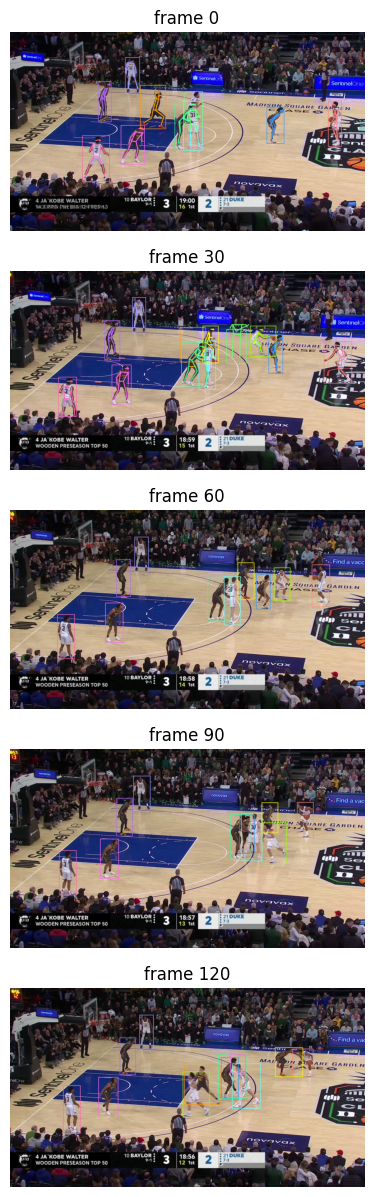

In [47]:
images = annotated_frames[:5]
titles = [f"frame {index * INTERVAL}" for index in range(0, len(images))]

sv.plot_images_grid(
    images=images,
    grid_size=(5, 1),
    size=(5, 15),
    titles=titles
)

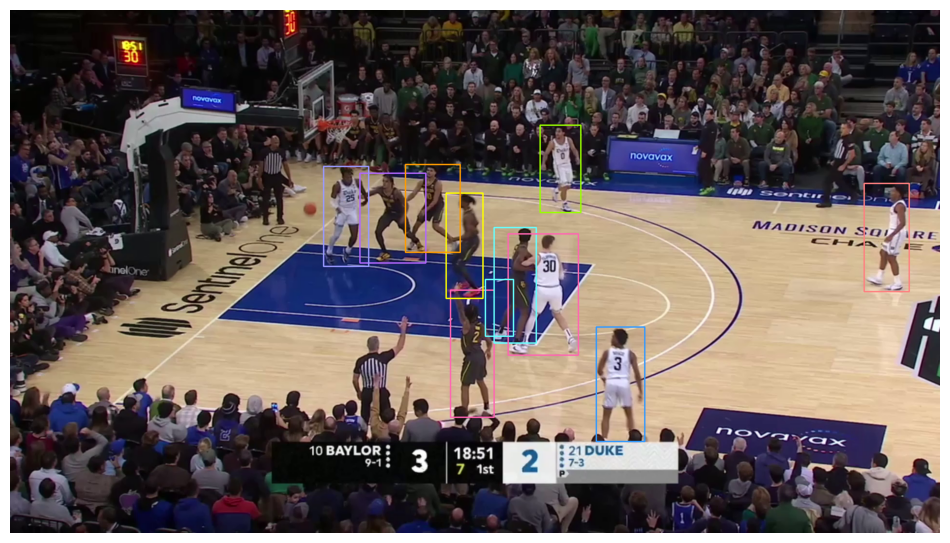

In [48]:
sv.plot_image(annotated_frames[-1])

## detect players ankles

In [49]:
def plot_ankles(key_points: sv.KeyPoints, tracker_ids: list[int], frame: np.array):
    key_points = key_points[:, [15, 16]]
    h, w = frame.shape[:2]
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))
    for tracker_id in tracker_ids:
        tracker_key_points = key_points[int(tracker_id) - 1]
        annotator = sv.VertexLabelAnnotator(
            color=COLOR.by_idx(tracker_id),
            text_color=sv.Color.BLACK,
            text_scale=text_scale,
            border_radius=2
        )
        frame = annotator.annotate(scene=frame, key_points=tracker_key_points, labels=["L", "R"])
    return frame

In [50]:
import cv2
import torch
from tqdm import tqdm

PLAYER_ID = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
INTERVAL = 30

annotated_frames = []

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == PLAYER_ID]

XYXY = detections.xyxy
CLASS_ID = detections.class_id
TRACKE_ID = list(range(1, len(CLASS_ID) + 1))

detections = sv.Detections(
    xyxy=XYXY,
    tracker_id=np.array(TRACKE_ID)
)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.load_first_frame(frame)

    for xyxy, tracker_id in zip(XYXY, TRACKE_ID):
        xyxy = np.array([xyxy])

        _, object_ids, mask_logits = predictor.add_new_prompt(
            frame_idx=0,
            obj_id=tracker_id,
            bbox=xyxy
        )

for index, frame in tqdm(enumerate(frame_generator)):

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        tracker_ids, mask_logits = predictor.track(frame)
        tracker_ids = np.array(tracker_ids)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        masks = np.array([
            filter_segments_by_distance(mask, distance_threshold=300)
            for mask
            in masks
        ])

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=tracker_ids
        )

    if index % INTERVAL == 0:

        boxes = sv.xyxy_to_xywh(detections.xyxy)
        inputs = pose_estimation_processor(frame, boxes=[boxes], return_tensors="pt").to(DEVICE)

        # This is MOE architecture, we should specify dataset indexes for each image in range 0..5
        inputs["dataset_index"] = torch.tensor([0], device=DEVICE)

        with torch.no_grad():
            outputs = pose_estimation_model(**inputs)

        results = pose_estimation_processor.post_process_pose_estimation(outputs, boxes=[boxes])
        key_points = sv.KeyPoints.from_transformers(results[0])

        annotated_frame = frame.copy()
        annotated_frame = plot_ankles(key_points=key_points, tracker_ids=detections.tracker_id, frame=annotated_frame)
        annotated_frames.append(annotated_frame)

NameError: name 'predictor' is not defined

In [ ]:
images = annotated_frames[:5]
titles = [f"frame {index * INTERVAL}" for index in range(0, len(images))]

sv.plot_images_grid(
    images=images,
    grid_size=(5, 1),
    size=(5, 15),
    titles=titles
)

In [ ]:
sv.plot_image(annotated_frames[-1])

In [ ]:
# TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.parent / f"{SOURCE_VIDEO_PATH.stem}-pose{SOURCE_VIDEO_PATH.suffix}"
# TARGET_VIDEO_COMPRESSED_PATH = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

# PLAYER_ID = 2
# CONFIDENCE_THRESHOLD = 0.3
# IOU_THRESHOLD = 0.7
# INTERVAL = 30

# video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

# result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
# detections = sv.Detections.from_inference(result)
# detections = detections[detections.class_id == PLAYER_ID]

# XYXY = detections.xyxy
# CLASS_ID = detections.class_id
# TRACKER_ID = list(range(1, len(CLASS_ID) + 1))

# detections = sv.Detections(
#     xyxy=XYXY,
#     tracker_id=np.array(TRACKER_ID)
# )

# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     predictor.load_first_frame(frame)

#     for xyxy, tracker_id in zip(XYXY, TRACKER_ID):
#         xyxy = np.array([xyxy])

#         _, object_ids, mask_logits = predictor.add_new_prompt(
#             frame_idx=0,
#             obj_id=tracker_id,
#             bbox=xyxy
#         )

# with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
#     for index, frame in tqdm(enumerate(frame_generator)):

#         with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#             tracker_ids, mask_logits = predictor.track(frame)
#             tracker_ids = np.array(tracker_ids)
#             masks = (mask_logits > 0.0).cpu().numpy()
#             masks = np.squeeze(masks).astype(bool)

#             masks = np.array([
#                 filter_segments_by_distance(mask, distance_threshold=300)
#                 for mask
#                 in masks
#             ])

#             detections = sv.Detections(
#                 xyxy=sv.mask_to_xyxy(masks=masks),
#                 mask=masks,
#                 tracker_id=tracker_ids
#             )

#         try:
#             boxes = sv.xyxy_to_xywh(detections.xyxy)
#             inputs = pose_estimation_processor(frame, boxes=[boxes], return_tensors="pt").to(DEVICE)

#             # This is MOE architecture, we should specify dataset indexes for each image in range 0..5
#             inputs["dataset_index"] = torch.tensor([0], device=DEVICE)

#             with torch.no_grad():
#                 outputs = pose_estimation_model(**inputs)

#             results = pose_estimation_processor.post_process_pose_estimation(outputs, boxes=[boxes])
#             key_points = sv.KeyPoints.from_transformers(results[0])

#             annotated_frame = frame.copy()
#             annotated_frame = convert_to_grayscale(annotated_frame)
#             annotated_frame = plot_skeletons(key_points=key_points, tracker_ids=detections.tracker_id, frame=annotated_frame)
#             annotated_frame = plot_ankles(key_points=key_points, tracker_ids=detections.tracker_id, frame=annotated_frame)
#         except:
#             print("no keypoints")
#             annotated_frame = frame.copy()

#         sink.write_frame(annotated_frame)

In [ ]:
# %%capture
# !ffmpeg -y -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

## calculate time in zone

In [ ]:
from typing import Dict
import numpy as np

class FPSBasedTimer:
    """
    A timer that calculates the duration each object has been detected based on frames
    per second (FPS). Timer resets when a tracker ID disappears for more than
    `max_missing_frames` frames.

    Attributes:
        fps (int): The frame rate of the video stream.
        frame_id (int): Current frame number.
        tracker_id2frame_id (Dict[int, int]): Maps each tracker's ID to the frame number
            of its most recent (re)appearance.
        tracker_id2misses (Dict[int, int]): Counts consecutive missed frames for each tracker.
        max_missing_frames (int): Number of allowed missed frames before removing a tracker.
    """

    def __init__(self, fps: int = 30, max_missing_frames: int = 5) -> None:
        self.fps = fps
        self.frame_id = 0
        self.max_missing_frames = max_missing_frames
        self.tracker_id2frame_id: Dict[int, int] = {}
        self.tracker_id2misses: Dict[int, int] = {}

    def tick(self, detections) -> np.ndarray:
        """
        Processes the current frame, updating time durations for each tracker.
        Only removes tracker after `max_missing_frames` consecutive missed frames.

        Args:
            detections: The current frame's detections. Must have .tracker_id attribute.

        Returns:
            np.ndarray: Time durations (in seconds) for each detection.
        """
        self.frame_id += 1
        detected_ids = set(detections.tracker_id)
        times = []

        # Update missing counts and remove IDs missing for too long
        for tracker_id in list(self.tracker_id2frame_id):
            if tracker_id not in detected_ids:
                self.tracker_id2misses[tracker_id] = self.tracker_id2misses.get(tracker_id, 0) + 1
                if self.tracker_id2misses[tracker_id] > self.max_missing_frames:
                    del self.tracker_id2frame_id[tracker_id]
                    del self.tracker_id2misses[tracker_id]
            else:
                self.tracker_id2misses[tracker_id] = 0

        # Add or refresh seen IDs
        for tracker_id in detected_ids:
            if tracker_id not in self.tracker_id2frame_id:
                self.tracker_id2frame_id[tracker_id] = self.frame_id

        # Calculate durations
        for tracker_id in detections.tracker_id:
            start_frame = self.tracker_id2frame_id[tracker_id]
            duration = (self.frame_id - start_frame) / self.fps
            times.append(duration)

        return np.array(times)

In [ ]:
def run_player_pose_estimation(frame, detections):
    boxes = sv.xyxy_to_xywh(detections.xyxy)
    inputs = pose_estimation_processor(frame, boxes=[boxes], return_tensors="pt").to(DEVICE)

    # This is MOE architecture, we should specify dataset indexes for each image in range 0..5
    inputs["dataset_index"] = torch.tensor([0], device=DEVICE)

    with torch.no_grad():
        outputs = pose_estimation_model(**inputs)

    results = pose_estimation_processor.post_process_pose_estimation(outputs, boxes=[boxes])
    return sv.KeyPoints.from_transformers(results[0])

In [ ]:
from sports.common.view import ViewTransformer
from sports.configs.basketball import BasketballCourtConfiguration

KEYPOINT_CONFIDENCE_THRESHOLD = 0.5
DETECTION_CONFIDENCE = 0.3
LEFT_PAINT_INDICES = [2, 3, 11, 9]
RIGHT_PAINT_INDICES = [21, 23, 30, 29]
POLYGONS_INDICES = [LEFT_PAINT_INDICES, RIGHT_PAINT_INDICES]

CONFIG = BasketballCourtConfiguration()
EDGES = [(p1 + 1, p2 + 1) for p1, p2 in CONFIG.edges]

def run_court_detection(frame):
    result = COURT_DETECTION_MODEL.infer(frame, confidence=DETECTION_CONFIDENCE)[0]
    key_points = sv.KeyPoints.from_inference(result)
    filter = key_points.confidence[0] > KEYPOINT_CONFIDENCE_THRESHOLD
    detected_key_points = key_points[:, filter]

    source_reference_xy = np.array(CONFIG.vertices)[filter]
    target_reference_xy = detected_key_points.xy[0]

    transformer = ViewTransformer(
        source=source_reference_xy,
        target=target_reference_xy
    )

    source_xy = np.array(CONFIG.vertices)
    target_xy = transformer.transform_points(points=source_xy)

    projected_key_points = sv.KeyPoints(
        xy=target_xy[np.newaxis, ...],
        confidence=key_points.confidence
    )
    return detected_key_points, projected_key_points


def run_paint_detection(projected_key_points):
    for indices in POLYGONS_INDICES:
        if all(projected_key_points[:, indices].confidence[0] > KEYPOINT_CONFIDENCE_THRESHOLD):
            return projected_key_points[:, indices].xy[0].astype(int)
    return None

In [ ]:
import numpy as np
from matplotlib.path import Path as MplPath

def is_in_polygon(polygon: np.ndarray, points: np.ndarray) -> np.ndarray:
    path = MplPath(polygon)
    return path.contains_points(points)

In [ ]:
PLAYER_ID = 2
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.7
INTERVAL = 30

TARGET_VIDEO_PATH = SOURCE_VIDEO_PATH.parent / f"{SOURCE_VIDEO_PATH.stem}-time{SOURCE_VIDEO_PATH.suffix}"
TARGET_VIDEO_COMPRESSED_PATH = TARGET_VIDEO_PATH.parent / f"{TARGET_VIDEO_PATH.stem}-compressed{TARGET_VIDEO_PATH.suffix}"

# define annotators
detected_vertex_annotator = sv.VertexAnnotator(color=MAGENTA_COLOR, radius=8)
projected_vertex_annotator = sv.VertexAnnotator(color=CYAN_COLOR, radius=8)

projected_edge_annotator = sv.EdgeAnnotator(
    color=CYAN_COLOR,
    thickness=2,
    edges=EDGES
)

mask_not_violated_annotator = sv.MaskAnnotator(
    color=sv.Color.from_hex("#33ff99"),
    opacity=0.5,
    color_lookup=sv.ColorLookup.INDEX
)
label_not_violated_annotator = sv.LabelAnnotator(
    color=sv.Color.from_hex("#33ff99"),
    text_color=sv.Color.BLACK,
    text_scale=1,
    color_lookup=sv.ColorLookup.INDEX,
    text_position = sv.Position.BOTTOM_CENTER
)
mask_violated_annotator = sv.MaskAnnotator(
    color=sv.Color.from_hex("#ff66b2"),
    opacity=0.5,
    color_lookup=sv.ColorLookup.INDEX
)
label_violated_annotator = sv.LabelAnnotator(
    color=sv.Color.from_hex("#ff66b2"),
    text_color=sv.Color.BLACK,
    text_scale=1,
    color_lookup=sv.ColorLookup.INDEX,
    text_position = sv.Position.BOTTOM_CENTER
)
halo_annotator = sv.HaloAnnotator(
    color=sv.Color.WHITE,
    color_lookup=sv.ColorLookup.INDEX,
    opacity=0.5,
)

# setup timer
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

TIMER = FPSBasedTimer(
    fps=video_info.fps,
    max_missing_frames=video_info.fps // 4
)

frame = next(frame_generator)

# detect players
result = PLAYER_DETECTION_MODEL.infer(frame, confidence=CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD)[0]
detections = sv.Detections.from_inference(result)
detections = detections[detections.class_id == PLAYER_ID]

XYXY = detections.xyxy
CLASS_ID = detections.class_id
TRACKER_ID = list(range(1, len(CLASS_ID) + 1))

detections = sv.Detections(
    xyxy=XYXY,
    tracker_id=np.array(TRACKER_ID)
)

# start tracking
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.load_first_frame(frame)

    for xyxy, tracker_id in zip(XYXY, TRACKER_ID):
        xyxy = np.array([xyxy])

        _, object_ids, mask_logits = predictor.add_new_prompt(
            frame_idx=0,
            obj_id=tracker_id,
            bbox=xyxy
        )

# track players
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for index, frame in tqdm(enumerate(frame_generator)):

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            tracker_ids, mask_logits = predictor.track(frame)
            tracker_ids = np.array(tracker_ids)
            masks = (mask_logits > 0.0).cpu().numpy()
            masks = np.squeeze(masks).astype(bool)

            masks = np.array([
                filter_segments_by_distance(mask, distance_threshold=150)
                for mask
                in masks
            ])

            detections = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=masks),
                mask=masks,
                tracker_id=tracker_ids
            )

        # detect court and paint
        detected_key_points, projected_key_points = run_court_detection(frame)
        paint_polygon = run_paint_detection(projected_key_points)

        try:
            # detect feet
            player_key_points = run_player_pose_estimation(frame, detections)
            player_key_points = player_key_points[:, [15, 16]]

            # detect players in paint
            if paint_polygon is not None:
                x_is_in_polygon = is_in_polygon(polygon=paint_polygon, points=player_key_points.xy[:, 0])
                y_is_in_polygon = is_in_polygon(polygon=paint_polygon, points=player_key_points.xy[:, 1])
                detections_in_polygon = detections[x_is_in_polygon & y_is_in_polygon]
            else:
                detections_in_polygon = sv.Detections.empty()
        except:
            print("no keypoints")
            detections_in_polygon = sv.Detections.empty()

        if len(detections_in_polygon) == 0:
            detections_in_polygon.tracker_id = np.array([], dtype=int)

        # calculate time in paint
        time_in_polygon = np.array(TIMER.tick(detections_in_polygon))
        is_violated = time_in_polygon > 3
        detections_violated = detections_in_polygon[is_violated]
        time_violated = [f"{t:.2f}" for t in time_in_polygon[is_violated]]
        detections_not_violated = detections_in_polygon[~is_violated]
        time_not_violated = [f"{t:.2f}" for t in time_in_polygon[~is_violated]]

        # draw results
        annotated_frame = frame.copy()
        annotated_frame = convert_to_grayscale(annotated_frame)
        blank_frame = annotated_frame.copy()

        if paint_polygon is not None:
            annotated_frame = sv.draw_filled_polygon(
                scene=annotated_frame,
                polygon=paint_polygon,
                color=CYAN_COLOR,
                opacity=0.6
            )

        annotated_frame = projected_edge_annotator.annotate(
            scene=annotated_frame,
            key_points=projected_key_points)
        annotated_frame = projected_vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=projected_key_points)
        annotated_frame = detected_vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=detected_key_points)
        annotated_frame = replace_masked_regions(
            source_frame=blank_frame,
            target_frame=annotated_frame,
            masks=masks
        )
        annotated_frame = mask_violated_annotator.annotate(
            scene=annotated_frame,
            detections=detections_violated
        )
        annotated_frame = mask_not_violated_annotator.annotate(
            scene=annotated_frame,
            detections=detections_not_violated
        )

        annotated_frame = label_violated_annotator.annotate(
            scene=annotated_frame,
            detections=detections_violated,
            labels=time_violated
        )
        annotated_frame = label_not_violated_annotator.annotate(
            scene=annotated_frame,
            detections=detections_not_violated,
            labels=time_not_violated
        )

        sink.write_frame(annotated_frame)

In [ ]:
%%capture
!ffmpeg -y -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>